## Neuroimaging analysis

In [364]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import nibabel as nib
import os
import glob
from os.path import join as opj
from mpl_toolkits.axes_grid1 import ImageGrid
from unet3D import *
from torchsummary import summary
import monai
from monai.transforms import *
from mpl_toolkits.axes_grid1 import ImageGrid
import ssim
import tqdm

from sklearn.model_selection import train_test_split
import wandb
wandb.login()

from torchvision.utils import make_grid
import shutil
import pandas as pd

from nibabel.processing import smooth_image
import seaborn as sns

from scipy import stats
from nilearn.image import mean_img
from sklearn.metrics import r2_score

In [2]:
base_path="/home/matteo/data/MRI-PET-AI"
config={}

cases=os.listdir(base_path)
exclude=['Scripts','temp','SubjectList.txt','Bay_7_Reconstruction_Log.xlsx','PBRKOA_KOA003_010818']

cases=[i for i in cases if i not in exclude]

In [3]:
label_dict={"HC":0, "CLB":1, "KOA":2}
inverse_label_dict={v:k for k,v in label_dict.items()}
labels=[]
for c in cases:
    cl=None
    if "HC" in c:
        cl="HC"
    elif "CLB" in c:
        cl="CLB"
    elif "KOA" in c:
        cl="KOA"
    if cl is not NoneFSL
        labels.append(label_dict[cl])
cases=[os.path.join(base_path,i) for i in cases if i not in exclude]

In [4]:
train_cases,test_cases,train_labels,test_labels=train_test_split(cases,labels,test_size=0.15,random_state=42)
# train_cases,val_cases,train_labels,val_labels=train_test_split(cases,labels,test_size=0.2)


print(f"[INFO] train cases: {len(train_cases)} test cases: {len(test_cases)}")

[INFO] train cases: 173 test cases: 31


In [5]:
class MRIPETDataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels,roi=(96,96,96), transform=None, target_transform=None,out_mask=True,return_path=True):
        self.paths = paths
        self.labels=labels
        self.transform = transform
        self.target_transform = target_transform
        self.roi=roi
        self.out_mask=out_mask
        self.return_path=return_path
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        
        images_path=glob.glob(opj(self.paths[idx],"*.nii.gz"))
        t1_path=[i for i in images_path if "T1" in i][0]
        pet_path=[i for i in images_path if "_suv_" in i][0]
        
        t1=nib.load(t1_path)
        pet=nib.load(pet_path)
        
        affine=pet.affine
        
        assert t1.shape==pet.shape
        half_shape=[s//2 for s in t1.shape]
        half_roi=[s//2 for s in self.roi]
        dim_0_start=half_shape[0]-half_roi[0]
        dim_0_end=half_shape[0]+half_roi[0]

        dim_1_start=half_shape[1]-half_roi[1]
        dim_1_end=half_shape[1]+half_roi[1]

        dim_2_start=half_shape[2]-half_roi[2]
        dim_2_end=half_shape[2]+half_roi[2]
        try:
            t1=t1.dataobj[dim_0_start:dim_0_end,dim_1_start:dim_1_end,dim_2_start:dim_2_end]
        except Exception as e:
            print(e)
            print(f"[ERROR] {pet_path} created problems.")
        try:
            pet=pet.dataobj[dim_0_start:dim_0_end,dim_1_start:dim_1_end,dim_2_start:dim_2_end]
        except Exception as e:
            print(e)
            print(f"[ERROR] {pet_path} created problems.")
        
        t1=torch.Tensor(np.expand_dims(t1,0))
        pet=torch.Tensor(np.expand_dims(pet,0))
        
        label=self.labels[idx]
        if self.transform:
            t1 = self.transform(t1)
        if self.target_transform:
            pet = self.target_transform(pet)
            
        if self.out_mask:
            mask=(t1>0)*1.
            if self.return_path:
                path=opj(self.paths[idx])
                return t1,pet,mask,label,path,affine
            else:
                return t1,pet,mask,label,affine
        else:
                         
            if self.return_path:
                path=opj(self.paths[idx])
                return t1,pet,label,path,affine
            else:
                return t1,pet, label,affine

In [6]:
BS=2
config["BS"]=BS

transform_mri=Compose([ScaleIntensityRangePercentiles(1,99,0,1)])
transform_pet=Compose([ScaleIntensity(0,1)])

train_dataset=MRIPETDataset(train_cases,train_labels,transform=transform_mri,target_transform=transform_pet)
test_dataset=MRIPETDataset(test_cases,test_labels,transform=transform_mri,target_transform=transform_pet)


train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size=BS,shuffle=True)
test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=BS,shuffle=True)




In [7]:
n_channels=32
ch_mults=(1,1,1,1)
is_attn=(False,False,False,True)
n_blocks=1
depthwise_separable=True

config["n_channels"]=n_channels
config["ch_mults"]=ch_mults
config["is_attn"]=is_attn
config["n_blocks"]=n_blocks
config["depthwise_separable"]=depthwise_separable

model=UNet3D(image_channels=1,n_channels=n_channels,ch_mults=ch_mults,is_attn=is_attn,n_blocks=n_blocks,depthwise_separable=depthwise_separable)

device="cuda:0"
model=model.to(device)
summary(model,(1,96,96,96))

model.load_state_dict(torch.load("models/unet_t12pet.pt_final.pt"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 96, 96, 96]             896
         GroupNorm-2       [-1, 32, 96, 96, 96]              64
             Swish-3       [-1, 32, 96, 96, 96]               0
            Conv3d-4       [-1, 32, 96, 96, 96]             896
            Conv3d-5       [-1, 32, 96, 96, 96]           1,056
    DepthSepConv3d-6       [-1, 32, 96, 96, 96]               0
         GroupNorm-7       [-1, 32, 96, 96, 96]              64
             Swish-8       [-1, 32, 96, 96, 96]               0
            Conv3d-9       [-1, 32, 96, 96, 96]             896
           Conv3d-10       [-1, 32, 96, 96, 96]           1,056
   DepthSepConv3d-11       [-1, 32, 96, 96, 96]               0
         Identity-12       [-1, 32, 96, 96, 96]               0
    ResidualBlock-13       [-1, 32, 96, 96, 96]               0
         Identity-14       [-1, 32, 96,

<All keys matched successfully>

In [8]:
os.makedirs("generated",exist_ok=True)


os.makedirs("generated/structural",exist_ok=True)
os.makedirs("generated/structural/CLB",exist_ok=True)
os.makedirs("generated/structural/HC",exist_ok=True)
os.makedirs("generated/structural/KOA",exist_ok=True)


os.makedirs("generated/original",exist_ok=True)
os.makedirs("generated/original/CLB",exist_ok=True)
os.makedirs("generated/original/HC",exist_ok=True)
os.makedirs("generated/original/KOA",exist_ok=True)

os.makedirs("generated/converted",exist_ok=True)
os.makedirs("generated/converted/CLB",exist_ok=True)
os.makedirs("generated/converted/HC",exist_ok=True)
os.makedirs("generated/converted/KOA",exist_ok=True)


In [113]:
t_ones=[]
y=[]
y_pred=[]
labels=[]
with torch.no_grad():
    for  t1,pet,mask,label,path,affine in tqdm.tqdm(test_dataset):
        labels.append(label)
        target_class=inverse_label_dict[label]
        target_name=path.split("/")[-1]
        
        structural=nib.Nifti1Image(t1.squeeze().numpy(),affine)
        nib.save(structural,f"generated/structural/{target_class}/{target_name}.nii.gz")
        t_ones.append(structural)
        
        
        pet_orig=nib.Nifti1Image(pet.squeeze().numpy(),affine)
        nib.save(pet_orig,f"generated/original/{target_class}/{target_name}.nii.gz")
        y.append(pet)
        
        pet_generated=model(t1.to(device).unsqueeze(0)).squeeze(0).cpu()
        
        y_pred.append(mask*pet_generated)
        
        pet_generated=nib.Nifti1Image((mask*pet_generated).squeeze().numpy(),affine)
        nib.save(pet_generated,f"generated/converted/{target_class}/{target_name}.nii.gz")
        

100%|███████████████████████████████████████████| 31/31 [00:17<00:00,  1.77it/s]


## Convert to MNI space 

guide: https://www.fmrib.ox.ac.uk/primers/intro_primer/ExBox17/IntroBox17.html

flirt Strucural to MNI -> T1toMNIlin.mat
fnirt T1toMNIlin to MNI -> T1_MNI

flirt PET to Structural 

Then combine PEt -> Structual -> MNI

In [21]:
os.listdir('generated/structural/KOA')

['PBRKOA_KOA048_120121.nii.gz',
 'PBRKOA_KOA036_103119.nii.gz',
 'PBRKOA_KOA006_052919_correctID.nii.gz',
 'PBRKOA_KOA037_012320.nii.gz',
 'PBRKOA_KOA055_012921.nii.gz',
 'PBRKOA_KOA048_103020.nii.gz',
 'PBRKOA_KOA037_112019.nii.gz',
 'PBRKOA_KOA038_011520.nii.gz',
 'PBRKOA_KOA024_060519.nii.gz']

#### Structural warping

In [37]:
FSLDIR="/usr/local/fsl/"

structural_mni_path="generated/structural_mni"

convert_to_mni=False

if convert_to_mni:

    os.makedirs(structural_mni_path,exist_ok=True)

    for subdir in os.listdir("generated/structural"):
        subdir_path=opj("generated/structural",subdir)
        filenames=os.listdir(subdir_path)
        for filename in tqdm.tqdm(filenames):

            #generate directory
            os.makedirs(opj(structural_mni_path,subdir),exist_ok=True)

            #compute inpute path and output
            in_file_path=opj("generated/structural",subdir,filename)

            ### LINEAR T1 to MNI
            outfilename=filename.replace(".nii.gz","_T1toMNIlin.nii.gz")
            outmatname=filename.replace(".nii.gz","_T1toMNIlin.mat")

            out_file_path=opj(structural_mni_path,subdir,outfilename)
            out_mat_path=opj(structural_mni_path,subdir,outmatname)

            !flirt -in {in_file_path} -ref {FSLDIR}/data/standard/MNI152_T1_2mm_brain.nii.gz -dof 12 -out {out_file_path} -omat {out_mat_path}


            ## NONLINEAR T1 to MNI
            config_fnirt_name=filename.replace(".nii.gz","_T1_2_MNI152_2mm.cnf")
            coef_name=filename.replace(".nii.gz","_T1toMNI_coef.nii.gz")
            warp_name=filename.replace(".nii.gz","_T1toMNI_warp.nii.gz")
            fnirt_name=filename.replace(".nii.gz","_T1_2_MNI152_2mm.nii.gz")

            config_fnirt_path=opj(structural_mni_path,subdir,config_fnirt_name)
            coef_path=opj(structural_mni_path,subdir,coef_name)
            warp_path=opj(structural_mni_path,subdir,warp_name)
            out_fnirt_path=opj(structural_mni_path,subdir,fnirt_name)

            !fnirt --in={in_file_path} --ref={FSLDIR}/data/standard/MNI152_T1_2mm_brain.nii.gz --aff={out_mat_path} --iout={out_fnirt_path} --cout={coef_path} --fout={warp_path}


#### Warp of the PET images

In [114]:
if True:
    pet_mni="generated/pet_mni"
    pet_converted_mni="generated/converted_mni"
    os.makedirs(pet_mni,exist_ok=True)
    os.makedirs(pet_converted_mni,exist_ok=True)

    for subdir in os.listdir("generated/structural"):
        subdir_path=opj("generated/original",subdir)
        filenames=os.listdir(subdir_path)
        for filename in tqdm.tqdm(filenames):
            
            #generate directory
            os.makedirs(opj(pet_mni,subdir),exist_ok=True)
            os.makedirs(opj(pet_converted_mni,subdir),exist_ok=True)
            
            
            in_file_path=opj("generated/original",subdir,filename)
            in_file_converted_path=opj("generated/converted",subdir,filename)
            reference_t1_native_path=opj("generated/structural",subdir,filename)
            out_mat_path=opj(pet_mni,subdir,filename.replace(".nii.gz","_PET_2_T1.mat"))
            out_file_path=opj(pet_mni,subdir,filename.replace(".nii.gz","_PET_2_T1.nii.gz"))
            
            final_pet_path=opj(pet_mni,subdir,filename.replace(".nii.gz","_PET_2_MNI.nii.gz"))
            final_pet_convert_path=opj(pet_converted_mni,subdir,filename.replace(".nii.gz","_PET_2_MNI.nii.gz"))
            
            
            warp_name=filename.replace(".nii.gz","_T1toMNI_warp.nii.gz")
            warp_path=opj(structural_mni_path,subdir,warp_name)
            #print(in_file_path,reference_t1_native_path)
            
            ### Linear PET to T1 to get mat file
            !flirt -in {in_file_path} -ref {reference_t1_native_path} -dof 12 -omat {out_mat_path} -out {out_file_path}
            
            ### NonLinear combination PET -> T1 native -> Standard

        
            !applywarp -i {in_file_path} -r {FSLDIR}/data/standard/MNI152_T1_2mm.nii.gz --premat={out_mat_path} -w {warp_path} -o {final_pet_path}
            !applywarp -i {in_file_converted_path} -r {FSLDIR}/data/standard/MNI152_T1_2mm.nii.gz --premat={out_mat_path} -w {warp_path} -o {final_pet_convert_path}

            
        
            # input_filename=
            # reference_t1_native=
            # out_mat_name=
            # out_file_name=
        
            #!flirt -in T2_brain.nii.gz -ref T1_brain.nii.gz -dof 12 -omat T2toT1_LS.mat -out T2toT1_LS
        
        
        

100%|█████████████████████████████████████████████| 7/7 [00:51<00:00,  7.29s/it]


### move all MNI images to specific directories

In [115]:
pet_final_mni="generated/original_final_mni"
pet_converted_final_mni="generated/converted_final_mni"
structural_converted_final_mni="generated/structural_final_mni"
os.makedirs(pet_final_mni,exist_ok=True)
os.makedirs(pet_converted_final_mni,exist_ok=True)
os.makedirs(structural_converted_final_mni,exist_ok=True)


for subdir in os.listdir("generated/structural"):
    subdir_path=opj("generated/original",subdir)
    filenames=os.listdir(subdir_path)
    for filename in tqdm.tqdm(filenames):
        os.makedirs(opj(pet_final_mni,subdir),exist_ok=True)
        os.makedirs(opj(pet_converted_final_mni,subdir),exist_ok=True)
        os.makedirs(opj(structural_converted_final_mni,subdir),exist_ok=True)
        
        fnirt_name=filename.replace(".nii.gz","_T1_2_MNI152_2mm.nii.gz")
        src_out_fnirt_path=opj(structural_mni_path,subdir,fnirt_name)

        src_final_pet_path=opj(pet_mni,subdir,filename.replace(".nii.gz","_PET_2_MNI.nii.gz"))
        src_final_pet_convert_path=opj(pet_converted_mni,subdir,filename.replace(".nii.gz","_PET_2_MNI.nii.gz"))
        
        dst_out_fnirt_path=opj(structural_converted_final_mni,subdir,fnirt_name)
        dst_final_pet_path=opj(pet_final_mni,subdir,filename.replace(".nii.gz","_PET_2_MNI.nii.gz"))
        dst_final_pet_convert_path=opj(pet_converted_final_mni,subdir,filename.replace(".nii.gz","_PET_2_MNI.nii.gz"))
        
        shutil.copy(src_out_fnirt_path,dst_out_fnirt_path)
        shutil.copy(src_final_pet_path,dst_final_pet_path)
        shutil.copy(src_final_pet_convert_path,dst_final_pet_convert_path)
        
        
        ### look for structual, original and converted pet files and copy them to right directories
        

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 41.87it/s]


## Load data in MNI space, load Atlas, select thalamus ad perform prior analysis and data analysis

### Thalamus correlations

In [116]:
atlas_path="HarvardOxford/HarvardOxford-sub-maxprob-thr25-2mm.nii.gz"
atlas_indices_path="HarvardOxford-Subcortical.csv"

In [117]:
df=pd.read_csv(atlas_indices_path)
df["label"]=df.index+1
df

left_thal_label=4
rigth_thal_label=15
atlas=nib.load(atlas_path).get_fdata()

In [169]:
## load original pet images in mni
labels=[]
pet_data=[]
converted_data=[]

smooth=True
smooth_fwmh=2

smooth_pet_data_path="generated/original_smoothed_final_mni"
os.makedirs(smooth_pet_data_path,exist_ok=True)


for subdir in os.listdir("generated/structural"):
    subdir_path=opj("generated/original",subdir)
    filenames=os.listdir(subdir_path)
    for filename in tqdm.tqdm(filenames):
        original_mni=os.path.join(pet_final_mni,subdir,filename.replace(".nii.gz","_PET_2_MNI.nii.gz"))
        converted_mni=os.path.join(pet_converted_final_mni,subdir,filename.replace(".nii.gz","_PET_2_MNI.nii.gz"))
        labels.append(subdir)
        
        pet=nib.load(original_mni)
        if smooth:
            os.makedirs(os.path.join(smooth_pet_data_path,subdir),exist_ok=True)

            out_smoothed=os.path.join(smooth_pet_data_path,subdir,filename.replace(".nii.gz","_PET_2_MNI.nii.gz"))
            
            pet=smooth_image(pet,smooth_fwmh)
            nib.save(pet,out_smoothed)
        
        converted=nib.load(converted_mni)
        
        pet_data.append(pet)
        converted_data.append(converted)
        

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 13.06it/s]


In [170]:
#check i file sono diversi!

a=pet_data[0].get_fdata()
b=converted_data[0].get_fdata()

print(np.sum(a==b), np.prod(a.shape))

print(np.array_equal(a,b,))


552183 902629
False


In [171]:
print(f"if {np.array_equal(a,b,)} is False then everything is ok")


if False is False then everything is ok


In [172]:
(atlas==4).shape

(91, 109, 91)

In [173]:
thal=(atlas==left_thal_label)*1.+(atlas==rigth_thal_label)*1.

thal=thal*1.
thal.shape,np.unique(thal,return_counts=True)

((91, 109, 91), (array([0., 1.]), array([900025,   2604])))

In [174]:
pet_thal=[]
converted_thal=[]

for p,c in tqdm.tqdm(zip(pet_data,converted_data)):
    p_thal_mean=np.mean(p.get_fdata()*thal)
    c_thal_mean=np.mean(c.get_fdata()*thal)
    
    pet_thal.append(p_thal_mean)
    converted_thal.append(c_thal_mean)
    
    



31it [00:00, 33.52it/s]


In [175]:
df=pd.DataFrame(columns=["Dataset","Original","Converted"])
df["Dataset"]=labels
df["Original"]=pet_thal
df["Converted"]=converted_thal
df["Indices"]=np.arange(len(df))
df

df2=pd.DataFrame(columns=["Dataset","value","type"])
df2["Dataset"]=labels+labels
df2["Value"]=pet_thal+converted_thal
df2["Type"]=["Original"]*len(labels)+["Converted"]*len(labels)

In [188]:

t_list=[]
t2_list=[]
p_list=[]
p2_list=[]

combo=[("HC","KOA"),("HC","CLB"),("KOA","CLB")]
significant=[]
significant_conv=[]
for c in combo:
    t,p=stats.ttest_ind(df[df.Dataset==c[0]]["Original"],df[df.Dataset==c[1]]["Original"])
    t2,p2=stats.ttest_ind(df[df.Dataset==c[0]]["Converted"],df[df.Dataset==c[1]]["Converted"])
    
    if p<0.05:
        significant.append(c)
    if p2<0.05:
        significant_conv.append(c)
    
    print(f"[INFO] Comparison between for original {c[0]} and  {c[1]}: t: {t} p: {p}")
    print(f"[INFO] Comparison between for converted {c[0]} and  {c[1]}: t: {t2} p: {p2}")
    print()

print()
print(f"[INFO] For original, differences between {significant} were signficant")
print(f"[INFO] For converted, differences between {significant_conv} were signficant")


[INFO] Comparison between for original HC and  KOA: t: 1.3897895785717373 p: 0.18629811307790195
[INFO] Comparison between for converted HC and  KOA: t: 2.744077860851193 p: 0.015827940449972384

[INFO] Comparison between for original HC and  CLB: t: -0.17905005503949994 p: 0.8596998315135246
[INFO] Comparison between for converted HC and  CLB: t: 0.3550072339763352 p: 0.7263004374959854

[INFO] Comparison between for original KOA and  CLB: t: -2.0881905515191357 p: 0.04856969783673359
[INFO] Comparison between for converted KOA and  CLB: t: -1.598679303546368 p: 0.12415626719410001


[INFO] For original, differences between [('KOA', 'CLB')] were signficant
[INFO] For converted, differences between [('HC', 'KOA')] were signficant


Text(0.5, 1.0, 'Original vs Synthetic PET Comparison')

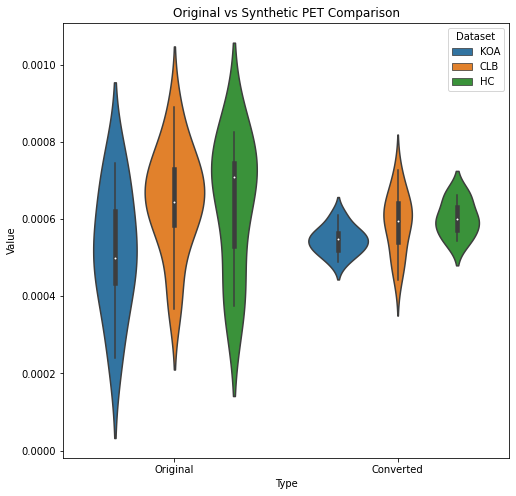

In [177]:
fig,axs =plt.subplots(1,1,figsize=(8,8))
ax=axs
sns.violinplot(data=df2,x="Type",y="Value",hue="Dataset",ax=ax)
ax.set_title("Original vs Synthetic PET Comparison")

### Generate mean images


In [183]:
np.array(pet_data)[np.array(labels)=="HC"]

array([<nibabel.nifti1.Nifti1Image object at 0x7efc67a66850>,
      dtype=object)

In [185]:
mean_original_hc=mean_img(np.array(pet_data)[np.array(labels)=="HC"])
mean_original_koa=mean_img(np.array(pet_data)[np.array(labels)=="KOA"])
mean_original_clb=mean_img(np.array(pet_data)[np.array(labels)=="CLB"])

mean_converted_hc=mean_img(np.array(converted_data)[np.array(labels)=="HC"])
mean_converted_koa=mean_img(np.array(converted_data)[np.array(labels)=="KOA"])
mean_converted_clb=mean_img(np.array(converted_data)[np.array(labels)=="CLB"])




In [380]:
mean_original_hc_smooth=smooth_image(mean_original_hc,fwhm=5)
mean_original_koa_smooth=smooth_image(mean_original_koa,fwhm=5)
mean_original_clb_smooth=smooth_image(mean_original_clb,fwhm=5)


In [186]:
mean_dir="generated/mean_imgs"
os.makedirs(mean_dir)

nib.save(mean_original_hc,os.path.join(mean_dir,"mean_original_hc.nii.gz"))
nib.save(mean_original_koa,os.path.join(mean_dir,"mean_original_koa.nii.gz"))
nib.save(mean_original_clb,os.path.join(mean_dir,"mean_original_clb.nii.gz"))

nib.save(mean_converted_hc,os.path.join(mean_dir,"mean_converted_hc.nii.gz"))
nib.save(mean_converted_koa,os.path.join(mean_dir,"mean_converted_koa.nii.gz"))
nib.save(mean_converted_clb,os.path.join(mean_dir,"mean_converted_clb.nii.gz"))

In [381]:
nib.save(mean_original_hc_smooth,os.path.join(mean_dir,"mean_original_hc_smooth.nii.gz"))
nib.save(mean_original_koa_smooth,os.path.join(mean_dir,"mean_original_koa_smooth.nii.gz"))
nib.save(mean_original_clb_smooth,os.path.join(mean_dir,"mean_original_clb_smooth.nii.gz"))

### Correlation between different areas

In [198]:
df_atlas=pd.read_csv(atlas_indices_path)
df_atlas["label"]=df_atlas.index+1
df_atlas.keys()

Index(['index', ' region', 'label'], dtype='object')

In [230]:
df_complete=pd.DataFrame(columns=["Dataset","value","type","area"])


In [239]:

pet_area_means=[]
pet_area_stds=[]

converted_area_means=[]
converted_area_stds=[]


#record for df_complete
pet_values=[]
conv_values=[]
area_values=[]
label_values=[]

pbar=tqdm.tqdm(np.arange(1,22))
for label_area in pbar:
    pet_area=[]
    converted_area=[]
    atlas_area=(atlas==label_area)*1.
    for p,c,l in zip(pet_data,converted_data,labels):
        p_mean=np.mean(p.get_fdata()*atlas_area)
        c_mean=np.mean(c.get_fdata()*atlas_area)
    
        pet_area.append(p_mean)
        converted_area.append(c_mean)
        
        #for df complete
        area_values.append(df_atlas[' region'].iloc[label_area-1])
        label_values.append(l)
        
    pet_values+=pet_area
    conv_values+=converted_area

        
    pet_area_means.append(np.mean(pet_area))
    pet_area_stds.append(np.std(pet_area))
    
    converted_area_means.append(np.mean(converted_area))
    converted_area_stds.append(np.std(converted_area))
    
    #pbar.set_description(f"[INFO] Processing area: {df_atlas[' region'].iloc[label_area-1]}")
    
    
    
    



100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  8.81it/s]


In [241]:
df_complete["Dataset"]=label_values+label_values
df_complete["value"]=pet_values+conv_values
df_complete["type"]=["original"]*len(pet_values)+["converted"]*len(conv_values)
df_complete["area"]=area_values+area_values

df_complete
# len(pet_values),len(conv_values),len(label_values),len(area_values)

,Dataset,value,type,area
0,KOA,0.004130,original,Left Cerebral White Matter
1,KOA,0.002740,original,Left Cerebral White Matter
2,KOA,0.005493,original,Left Cerebral White Matter
3,KOA,0.006601,original,Left Cerebral White Matter
4,KOA,0.004205,original,Left Cerebral White Matter
...,...,...,...,...
1297,HC,0.000017,converted,Right Accumbens
1298,HC,0.000016,converted,Right Accumbens
1299,HC,0.000018,converted,Right Accumbens
1300,HC,0.000020,converted,Right Accumbens


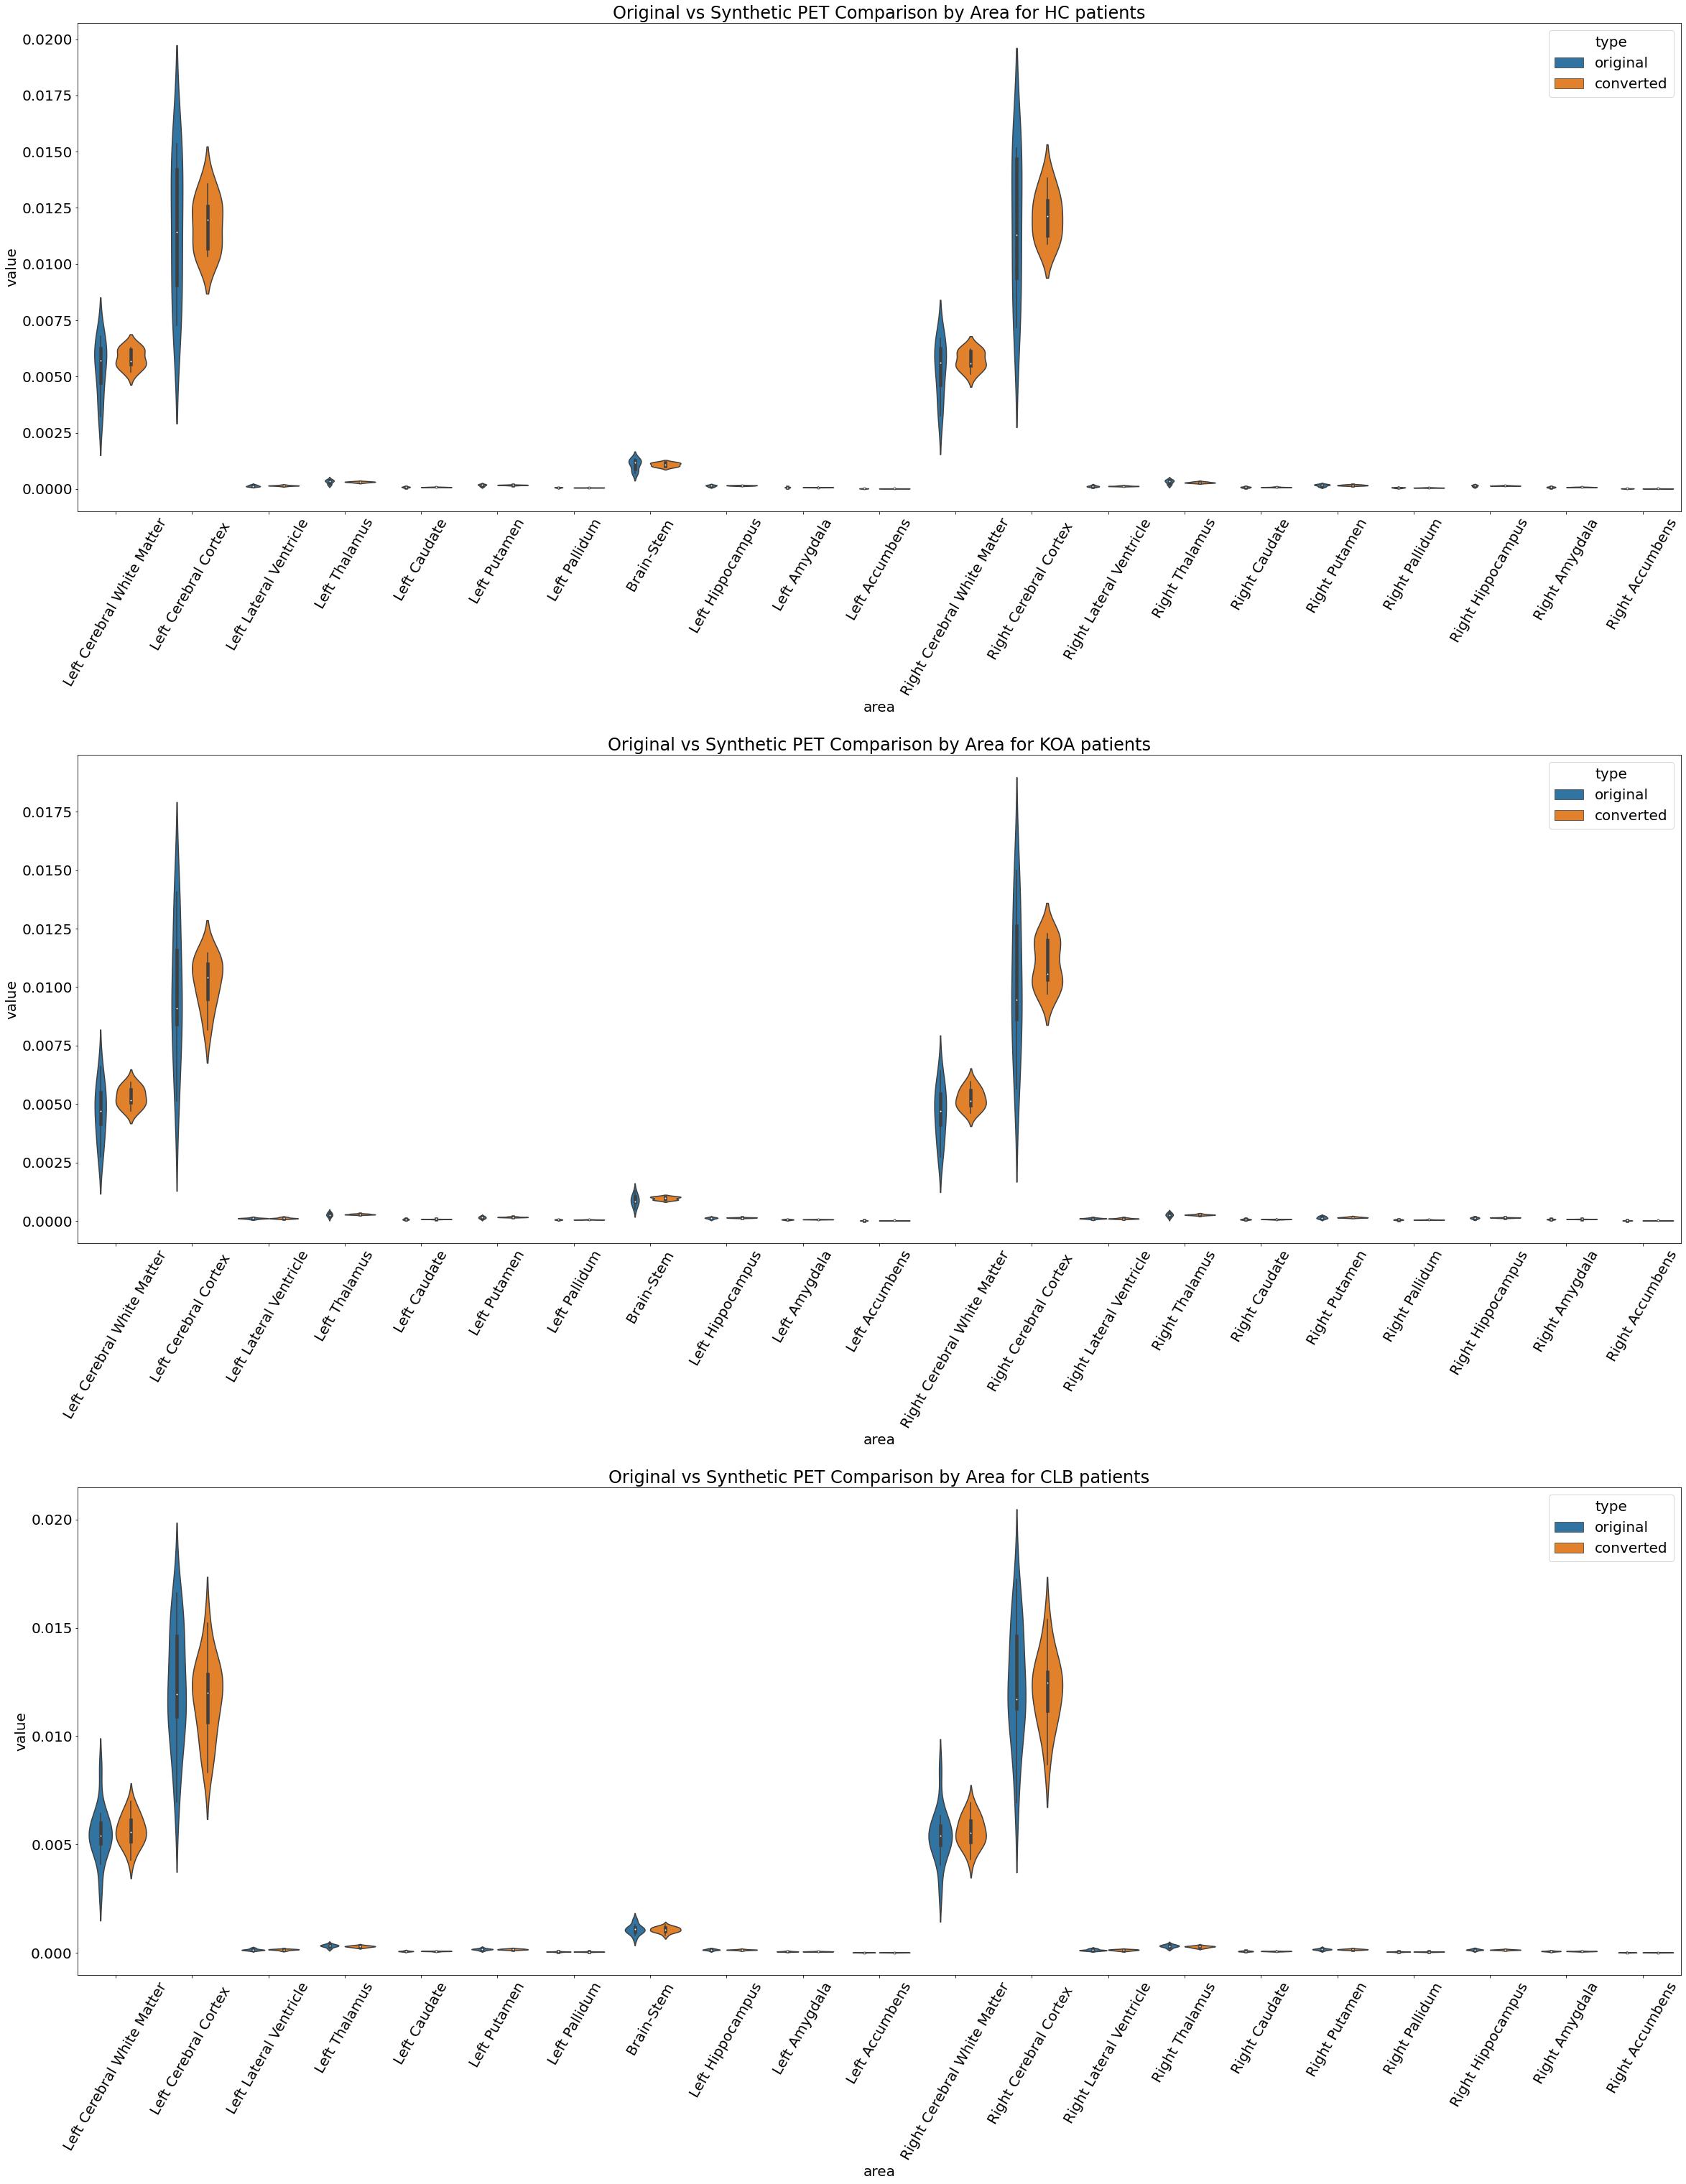

In [373]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
matplotlib.rc('font', size=20)


fig,axs =plt.subplots(3,1,figsize=(40,50))
ax=axs
sns.violinplot(data=df_complete[df_complete.Dataset=="HC"],x="area",y="value",hue="type",ax=axs[0])
axs[0].set_title("Original vs Synthetic PET Comparison by Area for HC patients")
axs[0].set_xticklabels(df_atlas[" region"],rotation = 60)

sns.violinplot(data=df_complete[df_complete.Dataset=="KOA"],x="area",y="value",hue="type",ax=axs[1])
axs[1].set_title("Original vs Synthetic PET Comparison by Area for KOA patients")
axs[1].set_xticklabels(df_atlas[" region"],rotation = 60)


sns.violinplot(data=df_complete[df_complete.Dataset=="CLB"],x="area",y="value",hue="type",ax=axs[2])
axs[2].set_title("Original vs Synthetic PET Comparison by Area for CLB patients")
axs[2].set_xticklabels(df_atlas[" region"],rotation = 60)

plt.subplots_adjust(hspace=0.5)


In [220]:
df_atlas["origin_average"]=pet_area_means
df_atlas["origin_std"]=pet_area_stds
df_atlas["converted_average"]=converted_area_means
df_atlas["converted_std"]=converted_area_stds

df_atlas

,index,region,label,origin_average,origin_std,converted_average,converted_std
0,0,Left Cerebral White Matter,1,0.005224,0.001227,0.005582,0.000595
1,1,Left Cerebral Cortex,2,0.011341,0.002980,0.011311,0.001611
2,2,Left Lateral Ventricle,3,0.000138,0.000038,0.000143,0.000029
3,3,Left Thalamus,4,0.000309,0.000078,0.000299,0.000030
4,4,Left Caudate,5,0.000079,0.000021,0.000080,0.000009
5,5,Left Putamen,6,0.000162,0.000041,0.000170,0.000018
6,6,Left Pallidum,7,0.000057,0.000014,0.000057,0.000006
7,7,Brain-Stem,8,0.001028,0.000247,0.001045,0.000110
8,8,Left Hippocampus,9,0.000139,0.000034,0.000145,0.000016
9,9,Left Amygdala,10,0.000064,0.000016,0.000067,0.000007


Text(0.5, 1.0, 'Comparison for each area of the average signal')

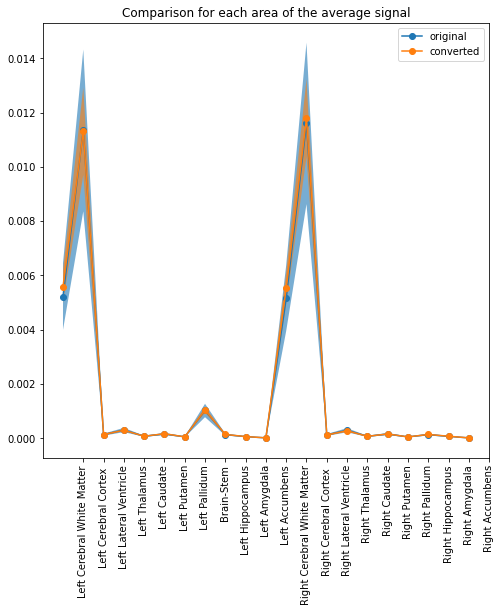

In [229]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
xlabel=list(df_atlas[" region"].values)
ax.plot(df_atlas["origin_average"],label="original",marker='o')
ax.fill_between(np.arange(len(df_atlas)),df_atlas["origin_average"]-df_atlas["origin_std"],df_atlas["origin_average"]+df_atlas["origin_std"],alpha=0.6)

ax.plot(df_atlas["converted_average"],label="converted",marker='o')
ax.fill_between(np.arange(len(df_atlas)),df_atlas["converted_average"]-df_atlas["converted_std"],df_atlas["converted_average"]+df_atlas["converted_std"],alpha=0.6)


ax.set_xticks(df_atlas["label"].values)
ax.set_xticklabels(xlabel,rotation='vertical')

plt.legend()
plt.title("Comparison for each area of the average signal")


### Identity check. Are converted patient and real ones along the identity line?

In [318]:
df_complete

,Dataset,value,type,area
0,KOA,0.004130,original,Left Cerebral White Matter
1,KOA,0.002740,original,Left Cerebral White Matter
2,KOA,0.005493,original,Left Cerebral White Matter
3,KOA,0.006601,original,Left Cerebral White Matter
4,KOA,0.004205,original,Left Cerebral White Matter
...,...,...,...,...
1297,HC,0.000017,converted,Right Accumbens
1298,HC,0.000016,converted,Right Accumbens
1299,HC,0.000018,converted,Right Accumbens
1300,HC,0.000020,converted,Right Accumbens


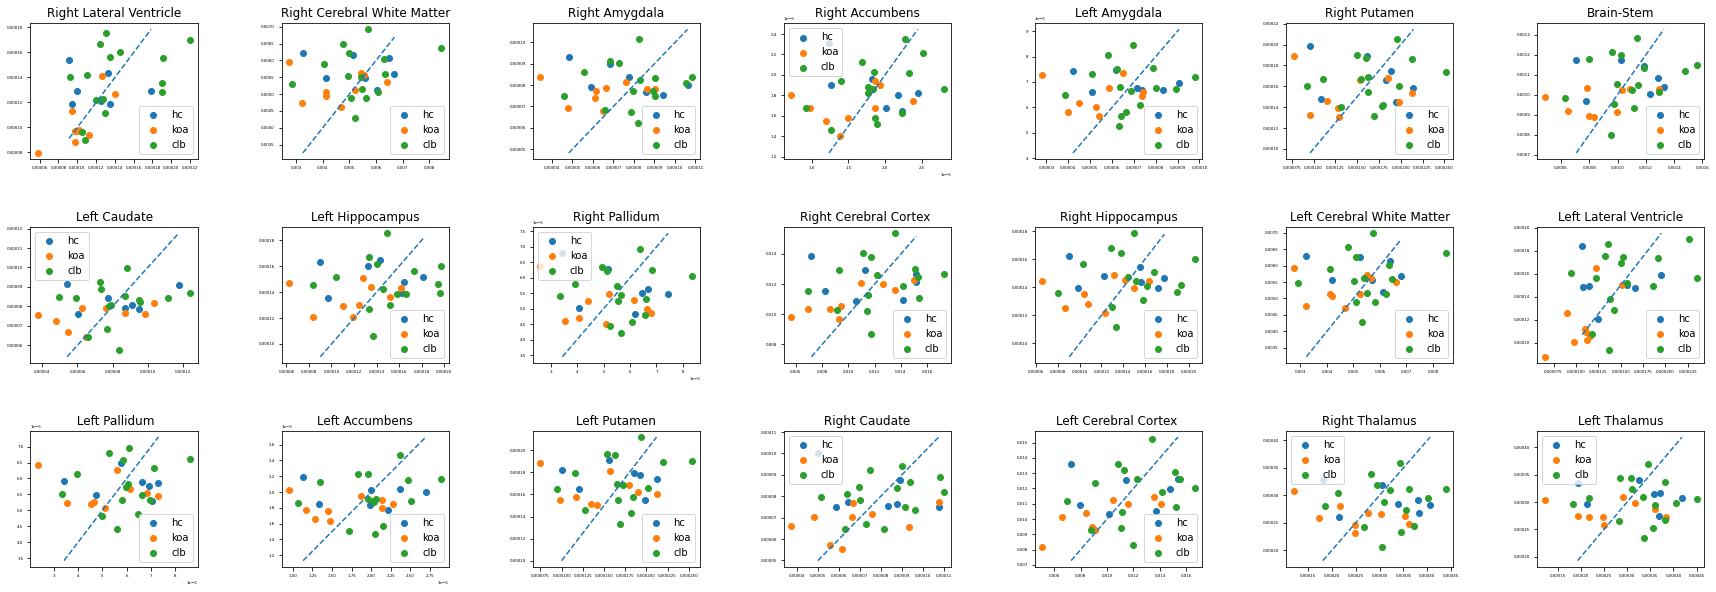

In [370]:
areas=list(set(df_complete.area))

a=areas[0]


cmap={"HC":"orange", "KOA":"tab:blue","CLB":"tab:green" }
colors=[cmap[i] for i in p.Dataset.iloc[:len(p)//2]]

fig,axs=plt.subplots(3,7,figsize=(30,10))

matplotlib.rc('xtick', labelsize=4) 
matplotlib.rc('ytick', labelsize=4) 

for i,ax in enumerate(axs.ravel()):
    
    p=df_complete[df_complete.area==areas[i]]

    x_hc_values=p[(p.type=="original") & (p.Dataset=="HC")].value
    y_hc_values=p[(p.type=="converted") & (p.Dataset=="HC")].value

    x_koa_values=p[(p.type=="original") & (p.Dataset=="KOA")].value
    y_koa_values=p[(p.type=="converted") & (p.Dataset=="KOA")].value

    x_clb_values=p[(p.type=="original") & (p.Dataset=="CLB")].value
    y_clb_values=p[(p.type=="converted") & (p.Dataset=="CLB")].value

    x_list=list(x_hc_values)+list(x_koa_values)+list(x_clb_values)
    y_list=list(y_hc_values)+list(y_koa_values)+list(y_clb_values)
    
    
    r2=r2_score(x_list,y_list)
    ax.scatter(x=x_hc_values,y=y_hc_values,label="hc")
    ax.scatter(x=x_koa_values,y=y_koa_values,label="koa")
    ax.scatter(x=x_clb_values,y=y_clb_values,label="clb")
    
    ax.plot(np.linspace(min(x_hc_values),max(x_hc_values),100),np.linspace(min(x_hc_values),max(x_hc_values),100),'--')
    ax.legend()
    ax.set_title(f"{areas[i]}")
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)

In [367]:
list(x_hc_values)+list(x_clb_values)

[0.0002132582526959716,
 0.0001930435207346156,
 0.00037033539472845685,
 0.00036895879178010997,
 0.00041845106216630473,
 0.0003255053313600927,
 0.00035745006498791917,
 0.00028438003164675123,
 0.00018207588012848268,
 0.00030727453679229525,
 0.00038275704220643215,
 0.00040622203611238823,
 0.00045043751899264637,
 0.00031100350460922996,
 0.000281433105070496,
 0.00035531849765918006,
 0.00021752838364977965,
 0.00034536701361153753,
 0.00033732165172988893,
 0.00033469396154026056,
 0.0003809334771675138,
 0.00036023347235246937]

In [346]:
len(areas)

21

In [336]:
x_values

array([['KOA', 0.00010056729148856377, 'original',
        'Right Lateral Ventricle'],
       ['KOA', 5.8264604378653816e-05, 'original',
        'Right Lateral Ventricle'],
       ['KOA', 0.00010183283636007585, 'original',
        'Right Lateral Ventricle'],
       ['KOA', 0.00011268578207910007, 'original',
        'Right Lateral Ventricle'],
       ['KOA', 0.00012680022970628215, 'original',
        'Right Lateral Ventricle'],
       ['KOA', 9.742280967600507e-05, 'original',
        'Right Lateral Ventricle'],
       ['KOA', 9.766017450974834e-05, 'original',
        'Right Lateral Ventricle'],
       ['KOA', 0.00013988234710647743, 'original',
        'Right Lateral Ventricle'],
       ['KOA', 9.472690816218813e-05, 'original',
        'Right Lateral Ventricle'],
       ['CLB', 0.00013072609038819694, 'original',
        'Right Lateral Ventricle'],
       ['CLB', 9.258136197802664e-05, 'original',
        'Right Lateral Ventricle'],
       ['CLB', 0.0001100729950337638, 'original

In [327]:
x_values

403    0.000101
404    0.000058
405    0.000102
406    0.000113
407    0.000127
408    0.000097
409    0.000098
410    0.000140
411    0.000095
412    0.000131
413    0.000093
414    0.000110
415    0.000128
416    0.000220
417    0.000190
418    0.000135
419    0.000105
420    0.000130
421    0.000124
422    0.000146
423    0.000108
424    0.000120
425    0.000190
426    0.000191
427    0.000100
428    0.000091
429    0.000133
430    0.000125
431    0.000178
432    0.000094
433    0.000135
Name: value, dtype: float64

## More statistical tests

### Mann-Withney U- Test. Check if Thalamus present differences with a non parameteric test

In [273]:
print("[INFO] Running Mann-Withney non parametrical Utest to assess differences between patient populations")
print()
s_list=[]
s2_list=[]
p_u_list=[]
p2_u_list=[]

combo=[("HC","KOA"),("HC","CLB"),("KOA","CLB")]
significant_u=[]
significant_u_conv=[]
for c in combo:
    s,p=stats.mannwhitneyu(df[df.Dataset==c[0]]["Original"],df[df.Dataset==c[1]]["Original"])
    s2,p2=stats.mannwhitneyu(df[df.Dataset==c[0]]["Converted"],df[df.Dataset==c[1]]["Converted"])
    
    if p<0.05:
        significant_u.append(c)
    if p2<0.05:
        significant_u_conv.append(c)
    
    print(f"[INFO] Comparison between for original {c[0]} and  {c[1]}: statistic: {t} p: {p}")
    print(f"[INFO] Comparison between for converted {c[0]} and  {c[1]}: statistic: {t2} p: {p2}")
    print()

print()
print(f"[INFO] For original, differences between {significant_u} were signficant")
print(f"[INFO] For converted, differences between {significant_u_conv} were signficant")


[INFO] Running Mann-Withney non parametrical Utest to assess differences between patient populations

[INFO] Comparison between for original HC and  KOA: statistic: -2.0881905515191357 p: 0.2104895104895105
[INFO] Comparison between for converted HC and  KOA: statistic: -1.598679303546368 p: 0.03111888111888112

[INFO] Comparison between for original HC and  CLB: statistic: -2.0881905515191357 p: 0.9452106201332205
[INFO] Comparison between for converted HC and  CLB: statistic: -1.598679303546368 p: 0.9452106201332205

[INFO] Comparison between for original KOA and  CLB: statistic: -2.0881905515191357 p: 0.0736382701203026
[INFO] Comparison between for converted KOA and  CLB: statistic: -1.598679303546368 p: 0.10740463633025366


[INFO] For original, differences between [] were signficant
[INFO] For converted, differences between [('HC', 'KOA')] were signficant


### Wilcoxon-Signed Rank test to check for variability between converted images and original ones

In [274]:
print("[INFO] Running  Wilcoxon signed-rank test to assess if statistical differences exist between generated and original images")
print()
sign=[]
for patient_group in ["HC","KOA","CLB"]:

    a=df[df.Dataset==patient_group]["Original"]
    b=df[df.Dataset==patient_group]["Converted"]
    stat,p=stats.wilcoxon(a,b)
    
    print(f"[INFO] Original/Converted  Wilcoxon signed-rank test  for {patient_group} p_value: {p}")
    if p<0.05:
        sign.append((patient,p))

print()

a=df["Original"]
b=df["Converted"]
stat,p=stats.wilcoxon(a,b)
print(f"[INFO] Original/Converted  Wilcoxon signed-rank test for all, p_value: {p}")

print()
if len(sign)==0:
    print("[INFO] No significant stastical differences found between real images and generated ones")
else:
    print(f"[INFO] Significat statistical differences found for {sign}")
     

[INFO] Running  Wilcoxon signed-rank test to assess if statistical differences exist between generated and original images

[INFO] Original/Converted  Wilcoxon signed-rank test  for HC p_value: 0.6875
[INFO] Original/Converted  Wilcoxon signed-rank test  for KOA p_value: 0.734375
[INFO] Original/Converted  Wilcoxon signed-rank test  for CLB p_value: 0.15142822265625

[INFO] Original/Converted  Wilcoxon signed-rank test for all, p_value: 0.27246372349830206

[INFO] No significant stastical differences found between real images and generated ones


In [209]:
df_atlas[" region"].values

array(['Left Cerebral White Matter', 'Left Cerebral Cortex ',
       'Left Lateral Ventricle', 'Left Thalamus', 'Left Caudate',
       'Left Putamen', ' Left Pallidum', 'Brain-Stem', 'Left Hippocampus',
       'Left Amygdala', 'Left Accumbens', 'Right Cerebral White Matter',
       'Right Cerebral Cortex ', 'Right Lateral Ventricle',
       'Right Thalamus', 'Right Caudate', 'Right Putamen',
       'Right Pallidum', 'Right Hippocampus', 'Right Amygdala',
       'Right Accumbens'], dtype=object)

# Voxel wise analysis  (option -T)


1) test between patient population. We want to test if there statistical differences in voxelwise median between different populations. We concatenate all patient of two population in 4D file,  with a design matrix one-hot-encoded and a contrast matrix [1 -1, -1 1] and peform 10000 permutations.

2) one sample t test, for testing between original and generated images. We compute the differences between generated and original and compute with null median as null hypothesis. Design matrix is just one column of ones, contrast is based on two rows, one column [1,-1]



se faccio un test appaiato
originale e vera

differenza tra immagini vera e ricostruita
randomize e testo la differenza -> design 1 colonna


contrasto 1 colonna 2 righe 1, -1

### Generate 4D images for voxelwise analysis

In [276]:
original_mni_pet_path="generated/original_final_mni"
converted_mni_pet_path="generated/converted_final_mni"

voxelwise_path="generated/voxelwise_analysis"
voxelwise_original_path="generated/voxelwise_analysis/original"
voxelwise_converted_path="generated/voxelwise_analysis/converted"

os.makedirs(voxelwise_path,exist_ok=True)
os.makedirs(voxelwise_original_path,exist_ok=True)
os.makedirs(voxelwise_converted_path,exist_ok=True)


In [295]:
#### 1. Comparison Original Images

print("[INFO] Generate concat images for ORIGINAL pet")
for c in tqdm.tqdm(combo):
    
    target_dir=os.path.join(voxelwise_original_path,"_".join(c))
    os.makedirs(target_dir,exist_ok=True)
    nib_list=[]
    design=[]
    for file in glob.glob(os.path.join(original_mni_pet_path,c[0],"*.nii.gz")):
        nib_list.append(nib.load(file))
        design.append([1, 0])
    
    for file in glob.glob(os.path.join(original_mni_pet_path,c[1],"*.nii.gz")):
        nib_list.append(nib.load(file))
        design.append([0,1])
    out=nib.funcs.concat_images(nib_list)
    nib.save(out,os.path.join(target_dir,f'{"_".join(c)}_concat.nii.gz'))
    design_txt=os.path.join(target_dir,f'{"_".join(c)}_concat_design.txt')
    contrast_txt=os.path.join(target_dir,f'{"_".join(c)}_concat_contrast.txt')
    
    np.savetxt(design_txt,np.array(design,dtype=int))
    np.savetxt(contrast_txt,np.array([[1,-1],[-1,1]],dtype=int))
    !Text2Vest {design_txt} {design_txt.replace(".txt",".mat")}
    !Text2Vest {contrast_txt} {contrast_txt.replace(".txt",".con")}
    

print("[INFO] Generate concat images for CONVERTED pet")
for c in tqdm.tqdm(combo):
    
    target_dir=os.path.join(voxelwise_converted_path,"_".join(c))
    os.makedirs(target_dir,exist_ok=True)
    nib_list=[]
    design=[]
    for file in glob.glob(os.path.join(converted_mni_pet_path,c[0],"*.nii.gz")):
        nib_list.append(nib.load(file))
        design.append([1, 0])
    
    for file in glob.glob(os.path.join(converted_mni_pet_path,c[1],"*.nii.gz")):
        nib_list.append(nib.load(file))
        design.append([0,1])
    out=nib.funcs.concat_images(nib_list)
    nib.save(out,os.path.join(target_dir,f'{"_".join(c)}_concat.nii.gz'))
    design_txt=os.path.join(target_dir,f'{"_".join(c)}_concat_design.txt')
    contrast_txt=os.path.join(target_dir,f'{"_".join(c)}_concat_contrast.txt')
    
    np.savetxt(design_txt,np.array(design,dtype=int))
    np.savetxt(contrast_txt,np.array([[1,-1],[-1,1]],dtype=int))
    !Text2Vest {design_txt} {design_txt.replace(".txt",".mat")}
    !Text2Vest {contrast_txt} {contrast_txt.replace(".txt",".con")}
    

[INFO] Generate concat images for ORIGINAL pet


100%|█████████████████████████████████████████████| 3/3 [00:06<00:00,  2.28s/it]


[INFO] Generate concat images for Converted pet


100%|█████████████████████████████████████████████| 3/3 [00:06<00:00,  2.16s/it]


In [307]:
run_converted_voxelwise_analysis=True
run_origin_voxelwise_analysis=True
run_compared_voxelwise_analysis=True

In [ ]:
mask_path="/usr/local/fsl/data/standard/MNI152_T1_2mm_brain_mask_dil.nii.gz"


if run_origin_voxelwise_analysis:
    N=10000
    for c in combo:
        compare="_".join(c)
        base_path=os.path.join(voxelwise_original_path,compare)
        !randomise -i {base_path}/{compare}_concat.nii.gz -d {base_path}/{compare}_concat_design.mat -t {base_path}/{compare}_concat_contrast.con -o {base_path}/{compare}_rand_out -m {mask_path} -n {N}

In [ ]:
print("ORIGIN VOXELWISE ANALYSIS COMPLETED")


In [ ]:
mask_path="/usr/local/fsl/data/standard/MNI152_T1_2mm_brain_mask_dil.nii.gz"


if run_converted_voxelwise_analysis:
    N=10000
    for c in combo:
        compare="_".join(c)
        base_path=os.path.join(voxelwise_converted_path,compare)
        !randomise -i {base_path}/{compare}_concat.nii.gz -d {base_path}/{compare}_concat_design.mat -t {base_path}/{compare}_concat_contrast.con -o {base_path}/{compare}_rand_out -m {mask_path} -T -D -n {N}

In [ ]:
print("CONVERTED VOXELWISE ANALYSIS COMPLETED")


### Generate diff images for voxelwise analysis between generated and original images

In [ ]:
diff_path=os.path.join(voxelwise_path,"diff")
original_mni_pet_path

for subdir in tqdm.tqdm(os.listdir(original_mni_pet_path)):
    for filename in os.listdir(os.path.join(original_mni_pet_path,subdir)):
        
        os.makedirs(os.path.join(diff_path,subdir),exist_ok=True)
        target=os.path.join(diff_path,subdir,filename)
        
        #load original
        orig_nib=nib.load(os.path.join(original_mni_pet_path,subdir,filename))
        aff=orig_nib.affine
        orig_data=orig_nib.get_fdata()
        
        
        #load converted
        converted_data=nib.load(os.path.join(converted_mni_pet_path,subdir,filename)).get_fdata()
        
        #compute difference
        
        diff=converted_data-orig_data
        
        #save difference
        diff_img=nib.Nifti1Image(diff,affine=aff)
        nib.save(diff_img,target)
        

In [ ]:
print(f"[INFO] Concatenating diff images")

for subdir in tqdm.tqdm(os.listdir(diff_path)):
    
    f=[]
    design=[]
    for filename in os.listdir(os.path.join(diff_path,subdir)):
        
        f.append(nib.load(os.path.join(diff_path,subdir,filename)))
        design.append(1)
    
    out=nib.funcs.concat_images(f)
    
    nib.save(out,os.path.join(diff_path,f'{subdir}_concat.nii.gz'))
    design_txt=os.path.join(diff_path,f'{subdir}_concat_design.txt')
    contrast_txt=os.path.join(diff_path,f'{subdir}_concat_contrast.txt')
    
    np.savetxt(design_txt,np.array(design,dtype=int))
    np.savetxt(contrast_txt,np.array([[1],[-1]],dtype=int))
    !Text2Vest {design_txt} {design_txt.replace(".txt",".mat")}
    !Text2Vest {contrast_txt} {contrast_txt.replace(".txt",".con")}

In [ ]:
mask_path="/usr/local/fsl/data/standard/MNI152_T1_2mm_brain_mask_dil.nii.gz"


if run_compared_voxelwise_analysis:
    N=10000
    for c in ["CLB","HC","KOA"]:
        compare=c
        base_path=diff_path
        !randomise -i {base_path}/{compare}_concat.nii.gz -d {base_path}/{compare}_concat_design.mat -t {base_path}/{compare}_concat_contrast.con -o {base_path}/{compare}_rand_out -m {mask_path} -T -n {N}

randomise options: -i generated/voxelwise_analysis/diff/CLB_concat.nii.gz -d generated/voxelwise_analysis/diff/CLB_concat_design.mat -t generated/voxelwise_analysis/diff/CLB_concat_contrast.con -o generated/voxelwise_analysis/diff/CLB_rand_out -m /usr/local/fsl/data/standard/MNI152_T1_2mm_brain_mask_dil.nii.gz -T -n 10000 
Loading Data: 
Data loaded
One-sample design detected; sign-flipping instead of permuting.
32768 sign-flips required for exhaustive test of t-test 1
Doing 10000 random permutations
Starting permutation 1 (Unpermuted data)
Starting permutation 2
Starting permutation 3
Starting permutation 4
Starting permutation 5
Starting permutation 6
Starting permutation 7
Starting permutation 8
Starting permutation 9
Starting permutation 10
Starting permutation 11
Starting permutation 12
Starting permutation 13
Starting permutation 14
Starting permutation 15
Starting permutation 16
Starting permutation 17
Starting permutation 18
Starting permutation 19
Starting permutation 20
Start

In [ ]:
print(f"[INFO] Completed Compared analysis")

## Average Images of all classes

In [79]:
label_dict

{'HC': 0, 'CLB': 1, 'KOA': 2}

In [80]:
labels=np.array(labels)
hc_indices=labels==0
clb_indices=labels==1
koa_indices=labels==2


In [81]:
hc_true=y[hc_indices]
hc_pred=y_pred[hc_indices]

clb_true=y[clb_indices]
clb_pred=y_pred[clb_indices]

koa_true=y[koa_indices]
koa_pred=y_pred[koa_indices]



In [90]:
hc_true_mean.max()

tensor(0.3659)

In [82]:
hc_true_mean=hc_true.mean(0).unsqueeze(0)
hc_pred_mean=hc_pred.mean(0).unsqueeze(0)

clb_true_mean=clb_true.mean(0).unsqueeze(0)
clb_pred_mean=clb_pred.mean(0).unsqueeze(0)

koa_true_mean=koa_true.mean(0).unsqueeze(0)
koa_pred_mean=koa_pred.mean(0).unsqueeze(0)



In [83]:
hc_true_mean_img=make_grid(hc_true_mean.permute(3,0,1,2),nrow=12)
clb_true_mean_img=make_grid(clb_true_mean.permute(3,0,1,2),nrow=12)
koa_true_mean_img=make_grid(koa_true_mean.permute(3,0,1,2),nrow=12)

hc_pred_mean_img=make_grid(hc_pred_mean.permute(3,0,1,2),nrow=12)
clb_pred_mean_img=make_grid(clb_pred_mean.permute(3,0,1,2),nrow=12)
koa_pred_mean_img=make_grid(koa_pred_mean.permute(3,0,1,2),nrow=12)


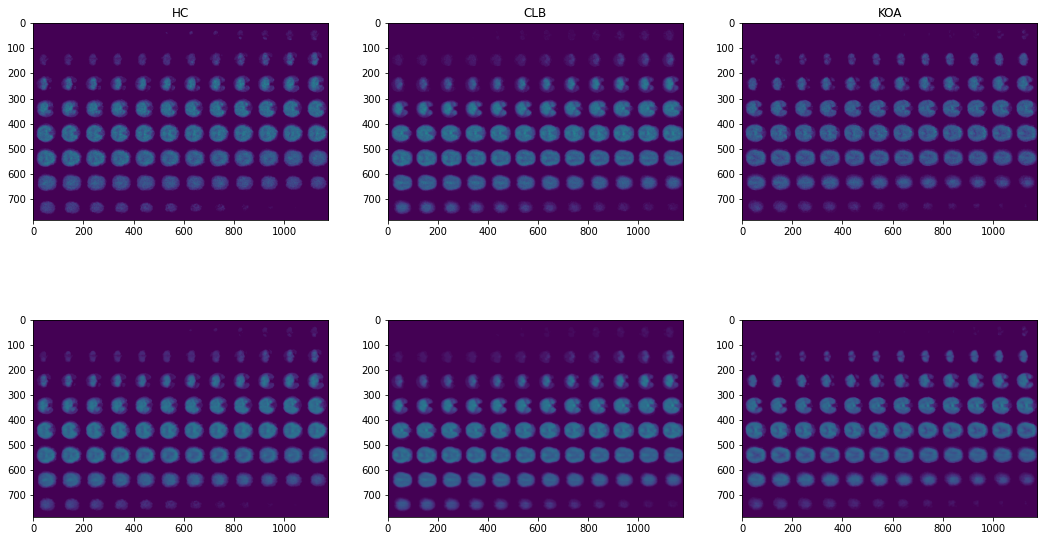

In [84]:
fig,axs=plt.subplots(2,3,figsize=(18,10))
axs[0,0].imshow(hc_true_mean_img[0:1,:,:].permute(1,2,0),cmap="viridis",vmin=0,vmax=0.5)
axs[0,0].set_title("HC")
axs[1,0].imshow(hc_pred_mean_img[0:1,:,:].permute(1,2,0),cmap="viridis",vmin=0,vmax=0.5)

axs[0,1].imshow(clb_true_mean_img[0:1,:,:].permute(1,2,0),cmap="viridis",vmin=0,vmax=0.5)
axs[0,1].set_title("CLB")
axs[1,1].imshow(clb_pred_mean_img[0:1,:,:].permute(1,2,0),cmap="viridis",vmin=0,vmax=0.5)

axs[0,2].imshow(koa_true_mean_img[0:1,:,:].permute(1,2,0),cmap="viridis",vmin=0,vmax=0.5)
axs[0,2].set_title("KOA")
axs[1,2].imshow(koa_pred_mean_img[0:1,:,:].permute(1,2,0),cmap="viridis",vmin=0,vmax=0.5)


In [105]:
hc_pred_mean[hc_pred_mean!=0].mean(),hc_pred_mean[hc_pred_mean!=0].std(),hc_pred_mean[hc_pred_mean!=0].max()

(tensor(0.1012), tensor(0.0592), tensor(0.2197))

In [110]:
hc_true_nifti=nib.Nifti1Image(hc_true_mean.squeeze().numpy(),np.eye(4))
hc_pred_nifti=nib.Nifti1Image(hc_pred_mean.squeeze().numpy(),np.eye(4))

clb_true_nifti=nib.Nifti1Image(clb_true_mean.squeeze().numpy(),np.eye(4))
clb_pred_nifti=nib.Nifti1Image(clb_pred_mean.squeeze().numpy(),np.eye(4))

koa_true_nifti=nib.Nifti1Image(koa_true_mean.squeeze().numpy(),np.eye(4))
koa_pred_nifti=nib.Nifti1Image(koa_pred_mean.squeeze().numpy(),np.eye(4))

nib.save(hc_true_nifti,"generated/original/hc_mean.nii.gz")
nib.save(hc_pred_nifti,"generated/converted/hc_mean.nii.gz")


nib.save(clb_true_nifti,"generated/original/clb_mean.nii.gz")
nib.save(clb_pred_nifti,"generated/converted/clb_mean.nii.gz")


nib.save(koa_true_nifti,"generated/original/koa_mean.nii.gz")
nib.save(koa_pred_nifti,"generated/converted/koa_mean.nii.gz")
